# Gegraphical data clustering

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim, ArcGIS, Photon
from geopy.extra.rate_limiter import RateLimiter
from sklearn.cluster import DBSCAN
import numpy as np
from geopy.exc import GeocoderUnavailable

In [ ]:
geolocator = Nominatim(user_agent='em_nome_do_pai')
# geolocator = Photon()
# geolocator = ArcGIS(username='cwrneiro', password='Chronos.42progoogle', referer='http://www.example.com')
delayed_geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

In [1]:
df = pd.read_parquet('stock.parquet')#.sample(n=50)
df.shape

(2413, 6)

In [2]:
df['full_address'] = df.street + ', ' + df.neighborhood
df.full_address

0                 Rua Lamute, São João Clímaco, São Paulo
1             Rua Galeno de Castro, Jurubatuba, São Paulo
2             Alameda Nothmann, Campos Elíseos, São Paulo
3        Rua Luís Correia de Melo, Santo Amaro, São Paulo
4                   Rua Jorge Rizzo, Pinheiros, São Paulo
                              ...                        
2408                 Rua Eleutério, Campo Belo, São Paulo
2409          Rua General Jardim, Vila Buarque, São Paulo
2410    Rua Paulo de Avelar, Vila Dom Pedro Ii, São Paulo
2411    Avenida Leonardo da Vinci, Vila Guarani (z Sul...
2412                Rua São Joaquim, Liberdade, São Paulo
Name: full_address, Length: 2413, dtype: object

In [ ]:
def get_lat_long(address: str):
    location = delayed_geocode(address)
    
    if location is not None:
        return location.latitude, location.longitude

    return None, None

In [3]:
'''
df[['latitude', 'longitude']] = df.full_address.apply(lambda address: pd.Series(get_lat_long(address)))
df
'''

df[['latitude', 'longitude']] = None, None

n_rows = 50

for i in range(len(df.index)//n_rows):
    print(f'Getting coordinates for columns {i*n_rows} to {(i+1)*n_rows}')

    df.iloc[i*n_rows:(i+1)*n_rows, [df.columns.get_loc(c) for c in ['latitude', 'longitude']]] = df.iloc[i*n_rows:(i+1)*n_rows].full_address.apply(lambda address: pd.Series(get_lat_long(address)))

    print(f'Success, with {df.iloc[i*n_rows:(i+1)*n_rows].isna().sum()}% na')


    file_path = f'data/chunk_{i}.parquet'
    
    print(f'Saving to {file_path}')

    df.iloc[i*n_rows:(i+1)*n_rows].to_parquet(file_path)

    print('Saved')

Getting coordinates for columns 0 to 50
Success, with suite_area       0
street           0
neighborhood     0
condominium      0
tax              0
asking_price     0
full_address     0
latitude        23
longitude       23
dtype: int64% na
Saving to data/chunk_0.parquet
Saved
Getting coordinates for columns 50 to 100
Success, with suite_area       0
street           0
neighborhood     0
condominium      0
tax              0
asking_price     0
full_address     0
latitude        24
longitude       24
dtype: int64% na
Saving to data/chunk_1.parquet
Saved
Getting coordinates for columns 100 to 150
Success, with suite_area       0
street           0
neighborhood     0
condominium      0
tax              0
asking_price     0
full_address     0
latitude        21
longitude       21
dtype: int64% na
Saving to data/chunk_2.parquet
Saved
Getting coordinates for columns 150 to 200
Success, with suite_area       0
street           0
neighborhood     0
condominium      0
tax              0
asking

In [ ]:
h
r"""°°°
é interessante rodar esse geocoding com todos os dados e salvar em parquet, pq tem que fazer devagar o geocoding pra n dar erro de mta request
°°°"""

In [4]:
from pathlib import Path

data_dir = Path('data')
df = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)
df.shape

(2400, 9)

In [5]:
df = df.dropna(
    subset=['latitude', 'longitude']
)
df.shape

(1357, 9)

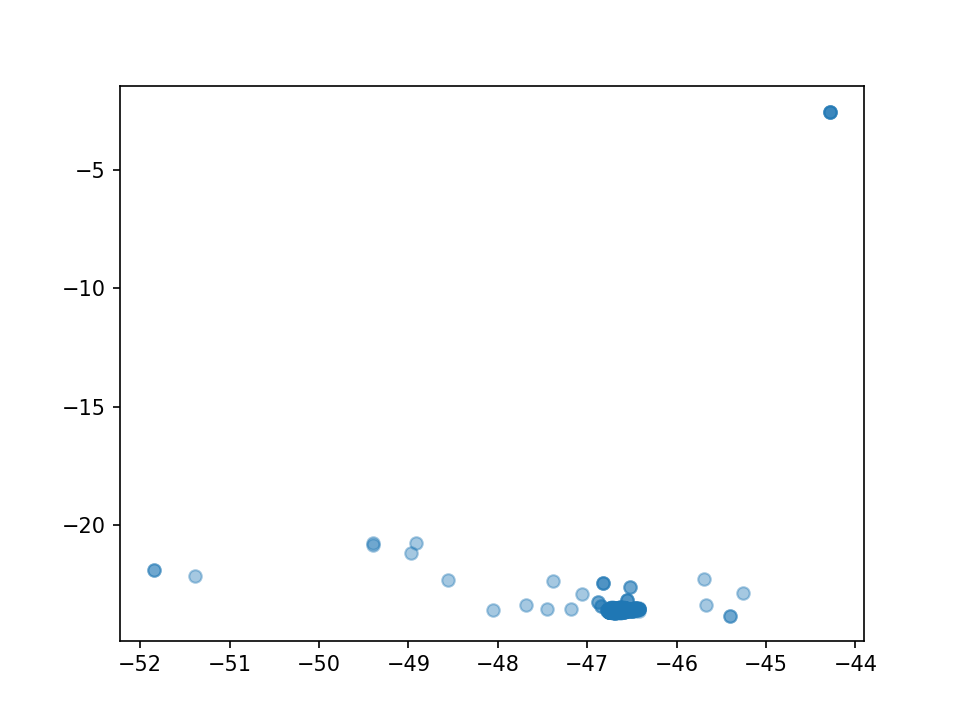

In [6]:
plt.scatter(df.longitude, df.latitude, alpha=0.4)

In [ ]:
db = DBSCAN(eps=0.2, min_samples=3).fit(df[['longitude', 'latitude']])
labels = db.labels_

In [ ]:
df['cluster'] = labels

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [7]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 23


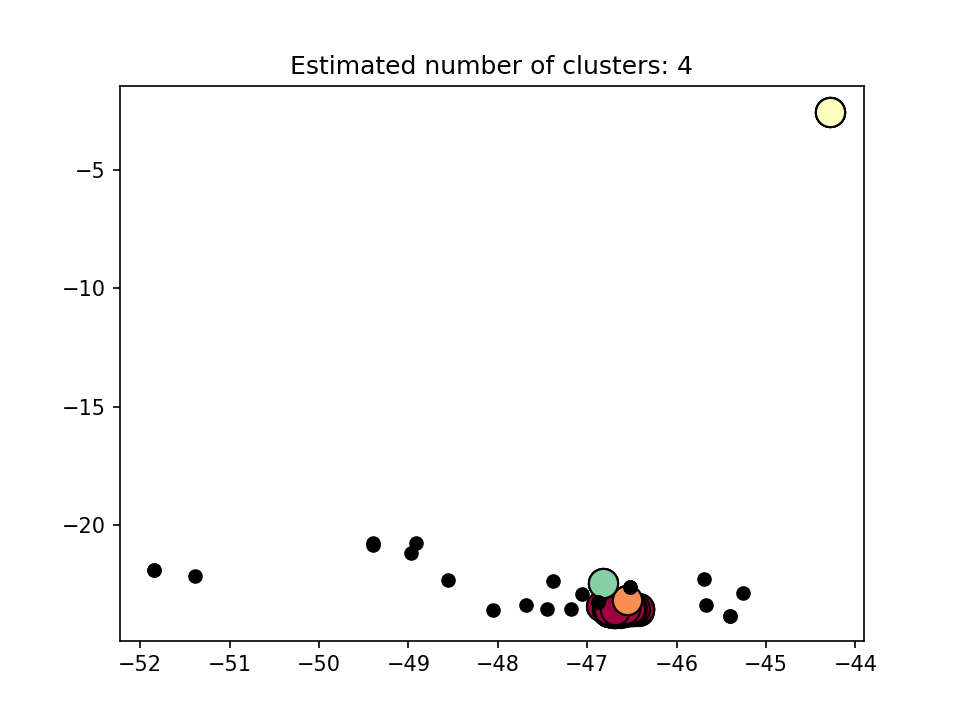

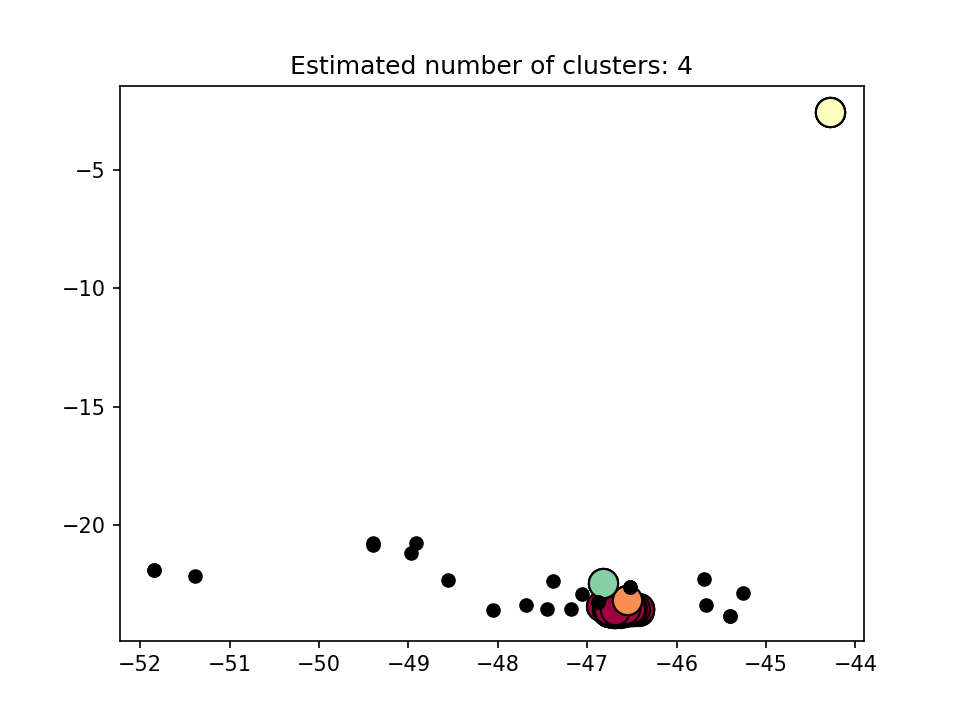

In [8]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(
        xy['longitude'],
        xy['latitude'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy['longitude'],
        xy['latitude'],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [9]:
from IPython.display import display

df.groupby('cluster').asking_price.mean()
df.groupby('cluster').asking_price.std()
display(df.groupby('cluster').describe())

        suite_area                                    ...  longitude                                            
             count       mean        std   min   25%  ...        min        25%        50%        75%        max
cluster                                               ...                                                       
-1            23.0  42.217391  13.697898  21.0  31.5  ... -51.847468 -48.940545 -47.384639 -46.517664 -45.260119
 0          1324.0  52.165408  31.571306  12.0  32.0  ... -46.842565 -46.674408 -46.639969 -46.606307 -46.416988
 1             3.0  53.666667  32.593455  27.0  35.5  ... -46.559450 -46.559450 -46.559450 -46.559450 -46.559450
 2             4.0  59.000000  11.575837  48.0  49.5  ... -44.283572 -44.283572 -44.283572 -44.283426 -44.282989
 3             3.0  38.333333   8.386497  33.0  33.5  ... -46.819336 -46.819336 -46.819336 -46.819336 -46.819336

[5 rows x 48 columns]
